In [480]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score,GridSearchCV

In [481]:
df = pd.read_excel('../data/model_annotations_liwc_h.xlsx')
df_human = pd.read_excel("../data/r1_r2_annotations_liwc_h.xlsx")

In [482]:
df_human.drop(['Segment','text','proc_text','A1','A2','A3','A4','A5','A6','roundID'], axis=1,inplace=True)
df_human=df_human[df_human['majority_vote']!='NoMajority']

In [450]:
df = df[~df.duplicated()]
df_human = df_human[~df_human.duplicated()]


In [451]:
df.head()

,text,proc_text,model_unanimous,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,"Dear World:family_man_woman_girl_boy:, you nee...","Dear World:family_man_woman_girl_boy:, you nee...",PO,1,32,52.84,75.49,1.63,1.00,16.0,...,0.0,0.0,59.38,3.13,6.25,0.0,0.0,0.00,50.00,12.5
1,.@fordnation says releasing the projection mod...,.@fordnation says releasing the projection mod...,PO,1,28,96.35,3.12,48.09,1.00,28.0,...,0.0,0.0,32.14,3.57,3.57,0.0,0.0,3.57,21.43,0.0
2,"""Neurologists around the world say that a smal...","""Neurologists around the world say that a smal...",UN,1,34,93.03,24.36,4.60,20.23,17.0,...,0.0,0.0,20.59,2.94,0.00,0.0,0.0,2.94,14.71,0.0
3,Coronavirus: More than one million cases confi...,Coronavirus: More than one million cases confi...,UN,1,34,93.03,40.06,12.44,1.85,17.0,...,0.0,0.0,14.71,5.88,0.00,0.0,0.0,0.00,8.82,0.0
4,"This is my Gov, @henrymcmaster, today, 4/2/202...","This is my Gov, @henrymcmaster, today, 4/2/202...",UN,1,42,81.45,54.27,72.58,3.20,10.5,...,0.0,0.0,38.10,7.14,11.90,0.0,0.0,2.38,16.67,0.0


In [452]:
df.drop(['Segment','text','proc_text'], axis=1,inplace=True)

In [453]:
y = df.pop('model_unanimous',)
y_human=df_human.pop('majority_vote')

In [454]:
round(y.value_counts()*100/len(y),3)

model_unanimous
PO    55.143
UN    37.490
PP     7.367
Name: count, dtype: float64

In [455]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, shuffle=True, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10142, 118), (2536, 118), (10142,), (2536,))

In [456]:
def reset_idx():
    X_train.reset_index(drop=True,inplace=True)
    X_test.reset_index(drop=True,inplace=True)
    y_train.reset_index(drop=True,inplace=True)
    y_test.reset_index(drop=True,inplace=True)

In [458]:
X_train.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [ ]:
X_train.isna().sum().sum()

In [459]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()

reg.fit(X_train, y_train)

y_pred_test=reg.predict(X_test)

print(classification_report(y_test,y_pred_test))

conf_m=confusion_matrix(y_test,y_pred_test)

ConfusionMatrixDisplay(conf_m).plot()

with open('models/regression_1.pkl','wb') as file:
    pickle.dump(reg, file)

In [461]:
def plot_pdf(data,r,c,size=(15,10)):
  plt.figure(figsize=size)
  for i in range(len(data.columns)):
    plt.subplot(r,c,i+1)
    sns.histplot(data[data.columns[i]],kde=True)
    plt.xlabel(data.columns[i])
    plt.grid()
  plt.show()

def plot_box(data,r,c,size=(15,10)):
  plt.figure(figsize=size)
  for i in range(len(data.columns)):
    plt.subplot(r,c,i+1)
    sns.boxplot(data[data.columns[i]])
    plt.xlabel(data.columns[i])
  plt.show()

In [462]:
plot_pdf(X_train,24,5, size=(50,100))

In [463]:
plot_box(X_train,24,5, size=(50,110))

I tried to perform feature selection, but there were no clear advantages, also in the final notebook the columns were already selected during the unsupervised step.

In [467]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

selector = RFE(RandomForestClassifier(),n_features_to_select=100)


selector.fit(X_train,y_train)

RFE(estimator=RandomForestClassifier(), n_features_to_select=100)

In [468]:
X_train=X_train[selector.get_feature_names_out()]
X_test=X_test[selector.get_feature_names_out()]

In [469]:
def evaluate_classifier(clf,X_train,y_train,X_test,y_test):
    print(f"TRAIN PERFORMANCE")
    y_pred_train=clf.predict(X_train)
    print(f"Cross validation scores: {cross_val_score(clf,X_train,y_train)}")

    print(classification_report(y_train,y_pred_train))

    conf_m=confusion_matrix(y_train,y_pred_train)

    ConfusionMatrixDisplay(conf_m).plot()


    print(f"\n\nTEST PERFORMANCE")
    y_pred_test=clf.predict(X_test)

    print(classification_report(y_test,y_pred_test))

    conf_m=confusion_matrix(y_test,y_pred_test)

    ConfusionMatrixDisplay(conf_m).plot()

c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

TRAIN PERFORMANCE


c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\cribr\.virtualenvs\supervised_part-u41BGbC3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Cross validation scores: [0.94036471 0.94381469 0.93934911 0.93195266 0.94230769]
              precision    recall  f1-score   support

          PO       0.96      0.98      0.97      5622
          PP       0.85      0.80      0.82       738
          UN       0.94      0.93      0.93      3782

    accuracy                           0.95     10142
   macro avg       0.92      0.90      0.91     10142
weighted avg       0.95      0.95      0.95     10142



TEST PERFORMANCE
              precision    recall  f1-score   support

          PO       0.96      0.97      0.96      1369
          PP       0.80      0.77      0.79       196
          UN       0.94      0.93      0.93       971

    accuracy                           0.94      2536
   macro avg       0.90      0.89      0.89      2536
weighted avg       0.94      0.94      0.94      2536



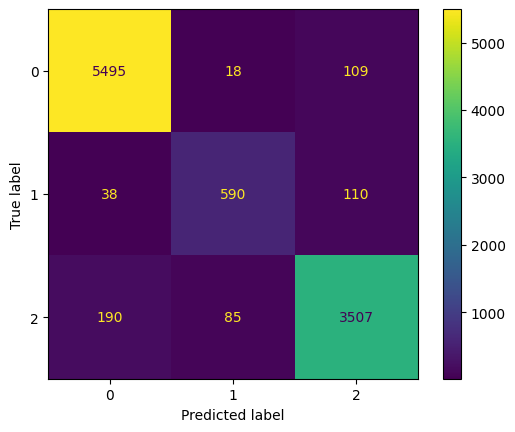

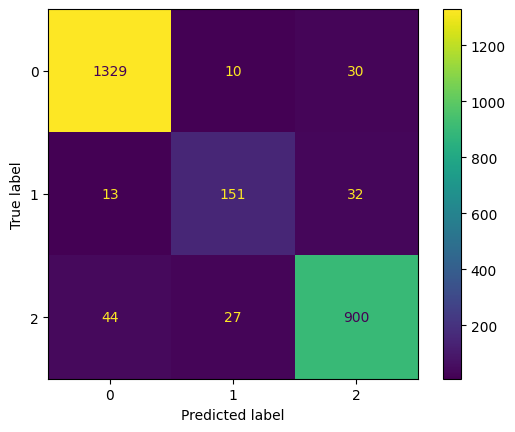

In [470]:
from sklearn.linear_model import LogisticRegression

param_grid={'penalty':['l1','l2',None],'C':[0.001,0.01,0.1,1,10]}

reg = GridSearchCV(LogisticRegression(max_iter=500),param_grid=param_grid)

reg.fit(X_train, y_train)

evaluate_classifier(reg,X_train,y_train,X_test,y_test)

In [471]:
from sklearn.ensemble import RandomForestClassifier

param_grid={'n_estimators':[100,500], 'max_depth': [3,5,10]}

rf = GridSearchCV(RandomForestClassifier(bootstrap=True),param_grid=param_grid)

rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 10], 'n_estimators': [100, 500]})

TRAIN PERFORMANCE
Cross validation scores: [0.94726466 0.95712173 0.94871795 0.95857988 0.95266272]
              precision    recall  f1-score   support

          PO       0.97      1.00      0.99      5622
          PP       0.99      0.92      0.95       738
          UN       0.99      0.97      0.98      3782

    accuracy                           0.98     10142
   macro avg       0.98      0.96      0.97     10142
weighted avg       0.98      0.98      0.98     10142



TEST PERFORMANCE
              precision    recall  f1-score   support

          PO       0.97      0.99      0.98      1369
          PP       0.90      0.65      0.75       196
          UN       0.94      0.96      0.95       971

    accuracy                           0.95      2536
   macro avg       0.94      0.87      0.89      2536
weighted avg       0.95      0.95      0.95      2536



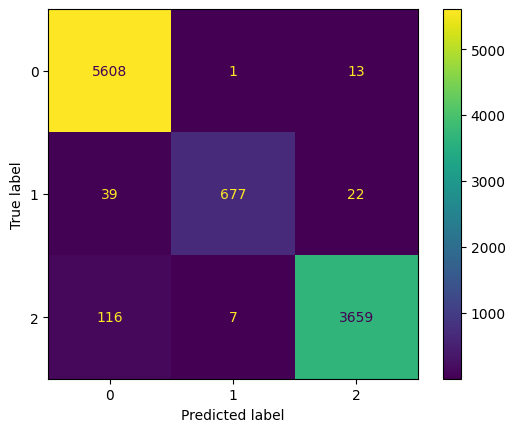

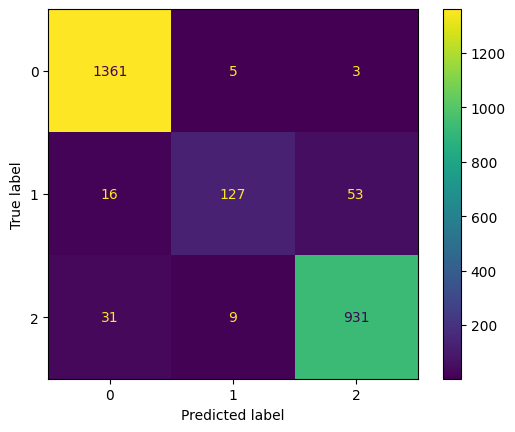

In [472]:
evaluate_classifier(rf,X_train,y_train,X_test,y_test)

In [473]:
df_human=df_human[selector.get_feature_names_out()]

In [474]:
len(df_human.columns)

100

In [475]:
len(X_test.columns)

100



OTHER TEST PERFORMANCE
              precision    recall  f1-score   support

          PO       0.93      0.72      0.81       160
          PP       0.94      0.77      0.84        95
          UN       0.64      0.98      0.77        98

    accuracy                           0.81       353
   macro avg       0.83      0.82      0.81       353
weighted avg       0.85      0.81      0.81       353



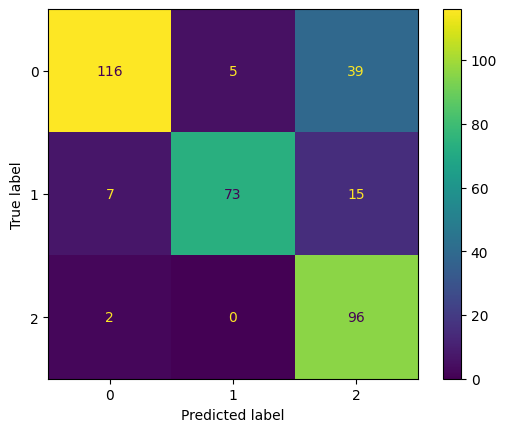

In [476]:
print(f"\n\nOTHER TEST PERFORMANCE")
y_pred_test2=rf.predict(df_human)

print(classification_report(y_human,y_pred_test2))

conf_m=confusion_matrix(y_human,y_pred_test2)

ConfusionMatrixDisplay(conf_m).plot()

We obtain a much worse performance on the human-annotated set.

In [478]:
with open('models/rf_1.pkl','wb') as file:
    pickle.dump(rf, file)